In [62]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [78]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-06-19 01:35:39--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-06-19 01:35:40--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.2MB/s    in 43s     

2025-06-19 01:36:23 (5.48 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [114]:
import os
import glob
import argparse
from types import SimpleNamespace
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from IPython.display import Image as ColabImage, display

In [74]:
# DATASET
class ColorizationDataset(Dataset):
  def __init__(self, image_paths, size=(256, 256)):
    self.paths = image_paths
    self.size = size

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    img = cv2.imread(self.paths[idx])
    img = cv2.cvtColor(cv2.resize(img, self.size), cv2.COLOR_BGR2RGB) / 255.0
    lab = rgb2lab(img)
    L = lab[:, :, 0:1] / 50.0 - 1.0
    ab = lab[:, :, 1:] / 128.0
    return (
      torch.tensor(L.transpose(2, 0, 1), dtype=torch.float32),
      torch.tensor(ab.transpose(2, 0, 1), dtype=torch.float32)
    )

In [75]:
# GENERATOR
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1), nn.ReLU(),
      nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
      nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
      nn.ConvTranspose2d(64, 2, 4, 2, 1), nn.Tanh()
    )

  def forward(self, x):
    return self.net(x)

In [76]:
# DISCRIMINATOR
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
      nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
      nn.Conv2d(128, 1, 4, 1, 0), nn.Sigmoid()
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
def postprocess(L, ab):
  L = L.detach().cpu().numpy()
  ab = ab.detach().cpu().numpy()

  L = (L + 1.0) * 50.0
  ab = ab * 128.0

  lab = np.concatenate([L, ab], axis=0).transpose(1, 2, 0)  # [C,H,W] → [H,W,C]
  rgb = lab2rgb(lab)  # Returns float32 image in [0,1]

  return torch.tensor(rgb).permute(2, 0, 1)

def train(args):
  extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPEG']
  paths = []
  for ext in extensions:
      paths += glob.glob(os.path.join(args.data_dir, '*', 'images', ext))

  if len(paths) == 0:
    raise ValueError(f"No images found in {args.data_dir}. Did you point to the class-folder parent?")

  paths = paths[:args.num_images]

  loader = DataLoader(ColorizationDataset(paths), batch_size=8, shuffle=True)

  G, D = Generator().cuda(), Discriminator().cuda()
  bce = nn.BCELoss()
  l1 = nn.L1Loss()
  opt_G = torch.optim.Adam(G.parameters(), lr=2e-4)
  opt_D = torch.optim.Adam(D.parameters(), lr=2e-4)

  for epoch in range(args.epochs):
    for i, (L, ab) in enumerate(loader):
      L, ab = L.cuda(), ab.cuda()
      fake_ab = G(L)
      fake_img = torch.cat([L, fake_ab], dim=1)
      real_img = torch.cat([L, ab], dim=1)

      # Train Discriminator
      D_real = D(real_img)
      D_fake = D(fake_img.detach())
      loss_D = bce(D_real, torch.ones_like(D_real)) + bce(D_fake, torch.zeros_like(D_fake))
      opt_D.zero_grad(); loss_D.backward(); opt_D.step()

      # Train Generator
      D_fake = D(fake_img)
      loss_G = bce(D_fake, torch.ones_like(D_fake)) + l1(fake_ab, ab) * 100
      opt_G.zero_grad(); loss_G.backward(); opt_G.step()

      if i % 1000 == 0:
        print(f"Epoch {epoch+1} Iter {i}: D_loss={loss_D.item():.3f} G_loss={loss_G.item():.3f}")
        save_image((postprocess(L[0].cpu(), fake_ab[0].cpu()).clamp(0, 1)),
                    f"{args.output_dir}/sample_epoch{epoch+1}_iter{i}.png")

    torch.save(G.state_dict(), os.path.join(args.output_dir, f'generator_epoch{epoch+1}.pth'))

def colorize_image(image_path, model_path, output_path='output_colorized.png'):
    # Load and resize image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    # Convert to LAB and extract L channel
    lab = rgb2lab(img / 255.0)
    L = lab[:, :, 0:1] / 50.0 - 1.0  # Normalize to [-1, 1]
    L_tensor = torch.tensor(L.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).cuda()

    # Load Generator
    G = Generator().cuda()
    G.load_state_dict(torch.load(model_path))
    G.eval()

    with torch.no_grad():
        fake_ab = G(L_tensor)[0]
        colorized = postprocess(L_tensor[0].cpu(), fake_ab.cpu()).clamp(0, 1)

    # Save result image
    save_image(colorized, output_path)

    # Prep visual versions
    original_tensor = torch.tensor(img / 255.0).permute(2, 0, 1)           # RGB [H,W,C] → [C,H,W]
    grayscale_tensor = L_tensor[0].cpu().repeat(3, 1, 1).clamp(0, 1)        # L → 3 channels

    return original_tensor, grayscale_tensor, colorized

if __name__ == "__main__":
  args = SimpleNamespace(
      data_dir='/content/tiny-imagenet-200/train',
      output_dir='/content/output',
      num_images=10000,
      epochs=15
  )

  os.makedirs(args.output_dir, exist_ok=True)
  train(args)

Epoch 1 Iter 0: D_loss=1.419 G_loss=34.947


/tmp/ipython-input-126-1586827890.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1176 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)  # Returns float32 image in [0,1]


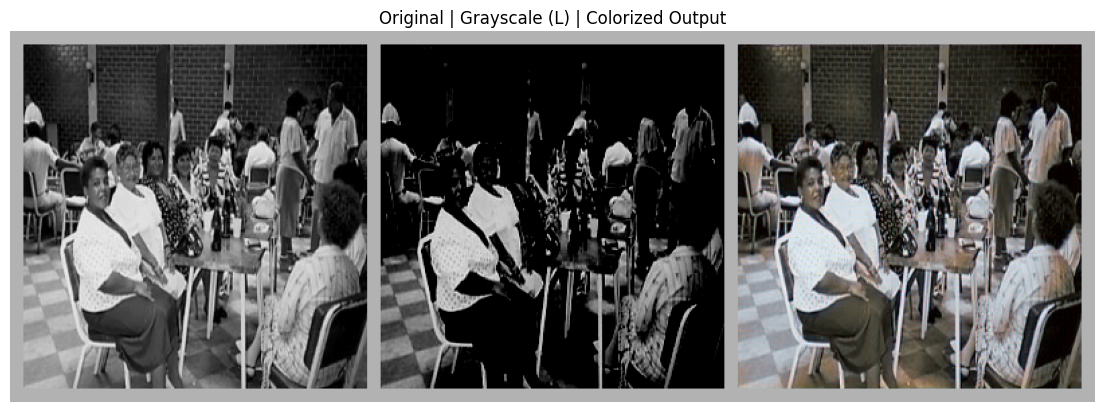

In [123]:
# Create a grid with padding and custom background color (e.g., gray)
grid = make_grid(
    [original, grayscale, colorized],
    nrow=3,
    padding=10,                # space between images
    pad_value=0.7              # gray background (0.0 = black, 1.0 = white)
)

plt.figure(figsize=(14, 5))
plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC for display
plt.axis('off')
plt.title("Original | Grayscale (L) | Colorized Output")
plt.show()